<a href="https://colab.research.google.com/github/lamsoa729/BPMSummerSchool/blob/main/Day6-Dedalus/lecture_3_active_nematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorial Equations & Analysis -- Active Nematics

**Overview:** This notebook describes how to construct a 2D active nematic simulation and analyze the output.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using global spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

**Author:** [Keaton Burns](http://keaton-burns.com)

# Setup

This cell checks if Dedalus is installed and performs some other basic setup.

If Dedalus is not installed and you are using Google Colab, it will automatically be installed.
This may take a few minutes the first time you run the notebook, but subsequent sessions during the next day or so should have the installation cached.
No need to worry about the details -- just execute the cell.

If you are not using Google Colab, follow the installation instructions in the [Dedalus Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus locally on your computer.
Installation using conda is typically straightforward for Mac and Linux.
No promises on Windows.
Execute the cell to confirm Dedalus is installed and importable.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


# Content

First let's import everything we need to run the rest of the notebook.

In [2]:
import numpy as np
np.seterr(over="raise")
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
%matplotlib widget

## 1. Setup domain and fields

We begin by setting up the domain for a 2D active nematic simulation.
We'll take as our domain a doubly-periodic box of size $L = 8 \pi$, discretized with $N$ Fourier modes in each dimension.

We first create a Cartesian coordinate system, then a Distributor object, and finally RealFourier bases for each dimension.
Since we'll be solving equations with cubic nonlinearities, we'll pick the dealias factors to be 2.

In [3]:
# Spatial discretization parameters
L = 8 * np.pi
N = 128
dealias = 2
dtype = np.float64

# Domain
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=N, bounds=(-L/2, L/2), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=N, bounds=(-L/2, L/2), dealias=dealias)

Next we create the fields we'll need for the simulation.
This includes a scalar field for pressure, a vector field for velocity, and 2nd order tensors for the conformation and alignment fields.
We also create a constant field $\tau_p$ which will be used to set the gauge freedom of the pressure.

In [4]:
# Fields
P = dist.Field(name='P', bases=(xbasis,ybasis))                        # Pressure
u = dist.VectorField(coords, name='u', bases=(xbasis,ybasis))          # Fluid Velocity
Q = dist.TensorField((coords,coords), name='Q', bases=(xbasis,ybasis)) # 2nd order Q-tensor (symmetric)
H = dist.TensorField((coords,coords), name='H', bases=(xbasis,ybasis)) # Alignment field
tau_p = dist.Field(name='tau_p')

## 2. Build problem and solver

Next we can build the Problem and Solver objects for our simulation.
We're solving the 2D Stokes equations with an active nematic tensor exerting a dipolar stress on the fluid:

$$- \nabla P + (\eta \Delta - \gamma) u + \nabla \cdot (\alpha Q + Q \cdot H - H \cdot Q)$$
$$\nabla \cdot u = 0$$
$$\partial_t Q + u \cdot \nabla Q + Q \nabla \cdot u - [Q \cdot \nabla u + (\nabla u)^T \cdot Q - 2 Q (Q : E)] = H$$
$$H = \Delta Q - k_s (Q : Q - S_0^2) Q$$

In this formulation there is a gauge freedom in the mean value of the pressure.
This gauge must be fixed to create a well-posed problem.
This is achieved by adding our undetermined constant field $c$ to the divergence equaion, effectively absorbing the mean mode which otherwise reads $0 = 0$.
This gives us the freedom to add an additional constraint fixing the pressure gauge.

In [5]:
# Physical parameters
eta = 1     # Relative viscosity
gamma = 0.1 # Friction
alpha = -8  # Dipole strength
ks = 10     # Spring constant of alignment field
S0 = 1      # Base order-parameter for spring field

# Problem
problem = d3.IVP([u, P, Q, H, tau_p], namespace=locals())
problem.add_equation("H - lap(Q) - ks * S0**2 * Q = -ks * Trace(Q@Q) * Q")
problem.add_equation("-grad(P) + eta*lap(u) - gamma*u + alpha*div(Q) = -div(Q@H - H@Q)")
problem.add_equation("dt(Q) - H = -u@grad(Q) + Q@grad(u) + (grad(u).T)@Q - 2*Q*Trace(Q@grad(u))")
problem.add_equation("div(u) + tau_p = 0")
problem.add_equation("integ(P) = 0");

Running multidimensional simulations on a single core in a notebook is rather slow, so we'll just run this simulation for a very short time for illustrative purposes.
The full script associated with this example is also available in the [online repository](https://github.com/lamsoa729/BPMSummerSchool), and this version can be easily ran at larger scale on a workstation or cluster.

In [6]:
# Temporal discretization parameters
timestepper = d3.RK443
initial_dt = 1e-2
safety = 0.5
stop_sim_time = 0.5

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2023-06-11 07:31:52,692 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.9e+01/s
2023-06-11 07:31:52,870 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.3e+01/s
2023-06-11 07:31:53,114 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 2s, Rate: 3.1e+01/s
2023-06-11 07:31:53,314 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.2e+01/s
2023-06-11 07:31:53,572 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.1e+01/s
2023-06-11 07:31:53,762 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 1s, Remaining: 1s, Rate: 3.2e+01/s
2023-06-11 07:31:53,970 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 1s, Remaining: 1s, Rate: 3.2e+01/s
2023-06-11 07:31:54,172 subsystems 0/1 INFO :: Building subproblem matri

Next we set the initial conditions directly using the field objects that we passed to the solver.
There are some helper methods for doing things like creating random initial data and applying simple filters.
Here we want to setup $Q$ as a symmetric tensor, so we simply populate it with noise and then replace the data with it's symmetric part.

We'll do this during the simulation, as well, to make sure the symmetry is maintained, so we can create an operator to evaluate the symmetric part and re-use it later.

In [7]:
# Initial conditions
I = dist.IdentityTensor(coords)
Q.fill_random(layout='g', seed=3)
Q.low_pass_filter(shape=(16, 16))
Q['g'] *= 1e-3
Q['g'][0,0] += 0.5
Q_sym = (Q + Q.T) / 2
Q['g'] = Q_sym.evaluate()['g']

## 4. Analysis tasks

To simplify saving simulation data, Dedalus includes a framework for evaluating and saving arbitrary analysis tasks while an initial value problem is running.
These analysis tasks can be specified symbolically and are saved to HDF5 files.

**Analysis handlers**

The explicit evaluation of analysis tasks during timestepping is controlled by the `solver.evaluator` object.
Various handler objects can be attached to the evaluator, and control when the evaluator computes their own set of tasks and what happens to the resulting data.
For simulation analysis, the most useful handler is the `FileHandler`, which regularly computes tasks and writes the data to HDF5 files. 

When setting up a file handler, you specify the name/path for the output directory/files, as well as the cadence at which you want the handler's tasks to be evaluated.
This cadence can be in terms of any combination of:
* simulation time, specified with `sim_dt`,
* wall time, specified with `wall_dt`
* iteration number, specified with `iter`

To limit file sizes, the output from a file handler is split up into different "sets" over time, each containing some number of writes that can be limited with the `max_writes` keyword when the file handler is constructed.
You can add an arbitrary number of file handlers to save different sets of tasks at different cadences and to different files.

**Analysis tasks**



Analysis tasks are added to a given handler using the `add_task` method. 
Tasks are entered as operator expressions or in plain text and parsed using the same namespace that is used for equation entry. 
For each task, you can additionally specify the output layout, scaling factors, and a referece name.

Let's create two different handlers, one for saving simulation snapshots, and one for saving scalar summary statistics at a higher cadence:

In [8]:
# Analysis parameters
snapshots_dt = 0.1
scalars_dt = 0.1

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=snapshots_dt, max_writes=1, parallel='gather')
snapshots.add_task(u)
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')
snapshots.add_task(Q)
snapshots.add_task(d3.Trace(Q @ Q.T), name='I2(Q)')

scalars = solver.evaluator.add_file_handler('scalars', sim_dt=scalars_dt, parallel='gather')
scalars.add_task(d3.Average(u@u/2), name='KE')

## 5. Adaptive timestepping and main loop

For more complex simulations, a constant timestep may be too restrictive, and we may want to choose the timestep adaptively based on a CFL criterion.
The Dedalus `CFL` tool allows you to do this, and has a number of optional parameters to prevent unneccesary timestep changes (which can be computationally costly) and to keep the timestep within reasonable bounds.

In [9]:
# CFL
cfl = d3.CFL(solver, initial_dt=initial_dt, cadence=10, safety=safety, max_change=1.5,
             min_change=0.5, max_dt=initial_dt, threshold=0.05)
cfl.add_velocity(u)

We can now run the simulation just as in the previous tutorial, but without needing to manually save any data during the main loop. 
The evaluator will automatically compute and save the specified analysis tasks at the proper cadence as the simulation is advanced.
First, we compute the new timestep every iteration using the `CFL.compute_timestep` method.
Then we step forward using this timestep, and symmetrize $Q$ using the operator we defined before.
At the end of the simulation, we can print some common run statistics with `solver.log_stats()`.

In [10]:
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        # Step
        timestep = cfl.compute_timestep()
        solver.step(timestep)
        # Symmetrize Q
        Q['c'] = Q_sym.evaluate()['c']
        # Log
        if (solver.iteration - 1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2023-06-11 07:31:55,620 __main__ 0/1 INFO :: Starting main loop
2023-06-11 07:31:56,614 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-02, dt=1.000000e-02
2023-06-11 07:31:59,410 __main__ 0/1 INFO :: Iteration=11, Time=1.100000e-01, dt=1.000000e-02
2023-06-11 07:32:02,360 __main__ 0/1 INFO :: Iteration=21, Time=2.100000e-01, dt=1.000000e-02
2023-06-11 07:32:05,419 __main__ 0/1 INFO :: Iteration=31, Time=3.100000e-01, dt=1.000000e-02
2023-06-11 07:32:08,434 __main__ 0/1 INFO :: Iteration=41, Time=4.100000e-01, dt=1.000000e-02
2023-06-11 07:32:11,062 solvers 0/1 INFO :: Simulation stop time reached.
2023-06-11 07:32:11,064 solvers 0/1 INFO :: Final iteration: 50
2023-06-11 07:32:11,067 solvers 0/1 INFO :: Final sim time: 0.5000000000000002
2023-06-11 07:32:11,070 solvers 0/1 INFO :: Setup time (init - iter 0): 3.016 sec
2023-06-11 07:32:11,071 solvers 0/1 INFO :: Warmup time (iter 0-10): 3.389 sec
2023-06-11 07:32:11,072 solvers 0/1 INFO :: Run time (iter 10-end): 12 sec
2023-06-11 07:

## 6. Post-processing

By default, the output files for each file handler are arranged as follows:

1. A base folder taking the name that was specified when the file handler was constructed, e.g. `scalars/`.
2. Within the base folder are HDF5 files for each output set, with the same name plus a set number, e.g. `scalars_s1.h5`.

Each HDF5 file contains a "tasks" group containing a dataset for each task assigned to the file handler. 
The first dimension of the dataset is time, the subsequent dimensions are the vector/tensor components of the task (if applicable), and finally the spatial dimensions of the task.

The HDF5 datasets are self-describing, with dimensional scales attached to each axis. 
For the first axis, these include the simulation time, wall time, iteration, and write number. 
For the spatial axes, the scales correspond to grid points or modes, based on the task layout.

We didn't run the simulation very long in the notebook, since the notebooks only run on a single core.
But the attached simulation script in the `lecture_3_data` folder can be used to run the same problem in parallel on a workstation or cluster for more time to produce a more interesting simulation.
I've done this offline, and included some of the output files under the `lecture_3_data` folder, as well.
Let's open up the scalar data from there, and plot a time series of the average kinetic energy in the flow:

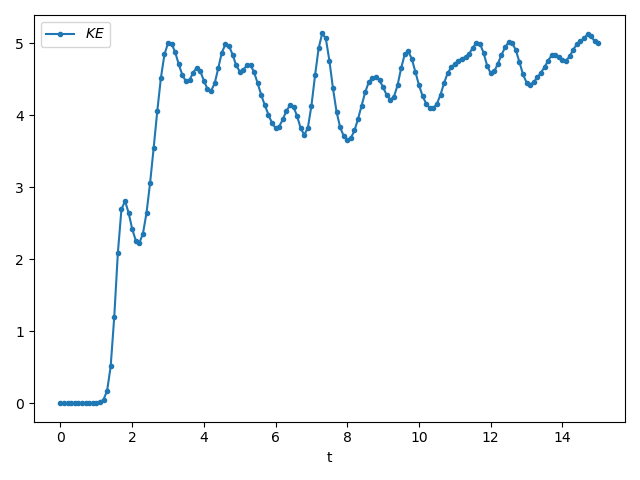

In [11]:
import h5py

# Load scalars
scalars = h5py.File('lecture_3_data/scalars/scalars_s1.h5', mode='r')
KE = scalars['tasks']['KE'][:]
t = scalars['tasks']['KE'].dims[0]['sim_time'][:]

# Plot data
plt.figure()
plt.plot(t, KE.ravel(), '.-', label=r'$KE$')
plt.xlabel('t')
plt.legend()
plt.tight_layout()


And let's plot the final vorticity snapshot:

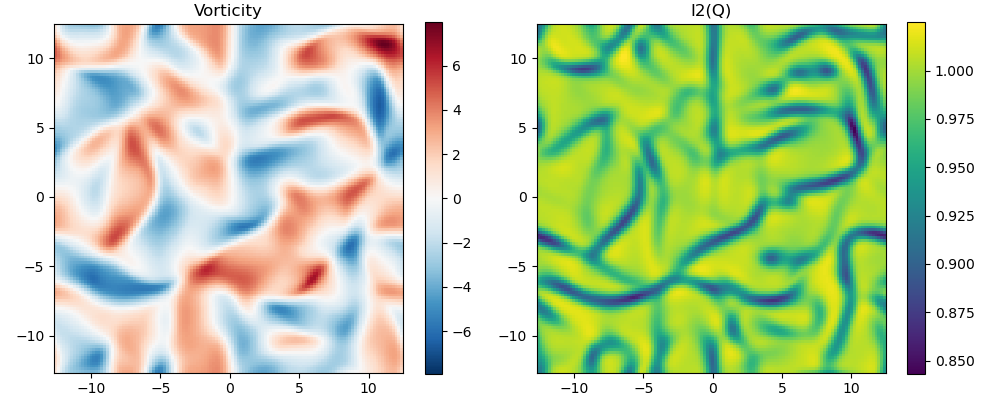

In [12]:
# Load snapshots
snapshots = h5py.File('lecture_3_data/snapshots/snapshots_s151.h5', mode='r')
vorticity = snapshots['tasks']['vorticity'][:]
I2 = snapshots['tasks']['I2(Q)'][:]
x = snapshots['tasks']['vorticity'].dims[1]['x'][:]
y = snapshots['tasks']['vorticity'].dims[2]['y'][:]

# Plot data
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
clim = np.max(np.abs(vorticity[-1]))
im = ax[0].pcolormesh(x, y, vorticity[-1].T, cmap='RdBu_r', clim=(-clim, clim))
ax[0].axis('scaled')
ax[0].set_title('Vorticity')
plt.colorbar(im)
im = ax[1].pcolormesh(x, y, I2[-1].T, cmap='viridis')
ax[1].axis('scaled')
ax[1].set_title('I2(Q)')
plt.colorbar(im)
plt.tight_layout()


The plotting script in the `lecture_3_data` folder makes similar plots for all the snapshots.
We can use it to make a video of all the snapshots that the simulation script produces:

In [13]:
from IPython.display import Video
Video("lecture_3_data/snapshots.mp4", embed=True, width=800)